## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import binarize
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Reshape
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
79394,00019499_004.png,No Finding,4,19499,56,M,AP,2500,2048,0.168,0.168,NaN,/data/images_009/images/00019499_004.png
8229,00002175_000.png,No Finding,0,2175,53,F,PA,2048,2500,0.171,0.171,NaN,/data/images_002/images/00002175_000.png
5660,00001526_005.png,Effusion|Infiltration|Pleural_Thickening,5,1526,17,M,PA,2746,2757,0.143,0.143,NaN,/data/images_002/images/00001526_005.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

df = all_xray_df.copy()

all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    class_label = c_label + "_class"
    if len(c_label)>1: # leave out empty labels
        df[class_label.lower()] = df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
48597,00012315_015.png,No Finding,15,12315,31,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
16807,00004519_001.png,No Finding,1,4519,57,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
82180,00020213_040.png,Consolidation|Infiltration,40,20213,72,F,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,0,0


In [4]:
df['pneumonia_class']

0         0
1         0
2         0
3         0
4         0
         ..
112115    1
112116    0
112117    0
112118    0
112119    0
Name: pneumonia_class, Length: 112120, dtype: int64

## Create your training and testing data:

In [5]:
def create_splits(df, test_size, target_column):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[target_column])
    
    return train_data, val_data

In [6]:
train_df, val_df = create_splits(df, 0.2, 'pneumonia_class')
print('train_df.shape:', train_df.shape)
print('val_df.shape:', val_df.shape)

train_df.shape: (89696, 28)
val_df.shape: (22424, 28)


In [7]:
train_df['pneumonia_class'].sum()/len(train_df)

0.012765340706386016

In [8]:
val_df['pneumonia_class'].sum()/len(val_df)

0.012754191937210132

In [9]:
p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [10]:
# Balance train set
train_df['pneumonia_class'].sum()/len(train_df)

0.5

In [11]:
train_df.shape

(2290, 28)

In [12]:
p_inds = val_df[val_df.pneumonia_class==1].index.tolist()
np_inds = val_df[val_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]

In [13]:
# Balance val set
val_df['pneumonia_class'].sum()/len(val_df)

0.2

In [14]:
val_df.shape

(1430, 28)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [15]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(target_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = "path",
                                         y_col = 'pneumonia_class',
                                         class_mode = 'raw',
                                         target_size = target_size, 
                                         batch_size = batch_size
                                         )

    return train_gen


def make_val_gen(target_size, batch_size):
    
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_df, 
                                             directory=None, 
                                             shuffle = False,
                                             x_col = "path",
                                             y_col = 'pneumonia_class',
                                             class_mode = 'raw',
                                             target_size = target_size, 
                                             batch_size = batch_size
                                             )
    
    return val_gen

In [16]:
batch_size = 64
target_size = (224, 224)

train_gen = make_train_gen(target_size, batch_size)
val_gen = make_val_gen(target_size, batch_size)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [17]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

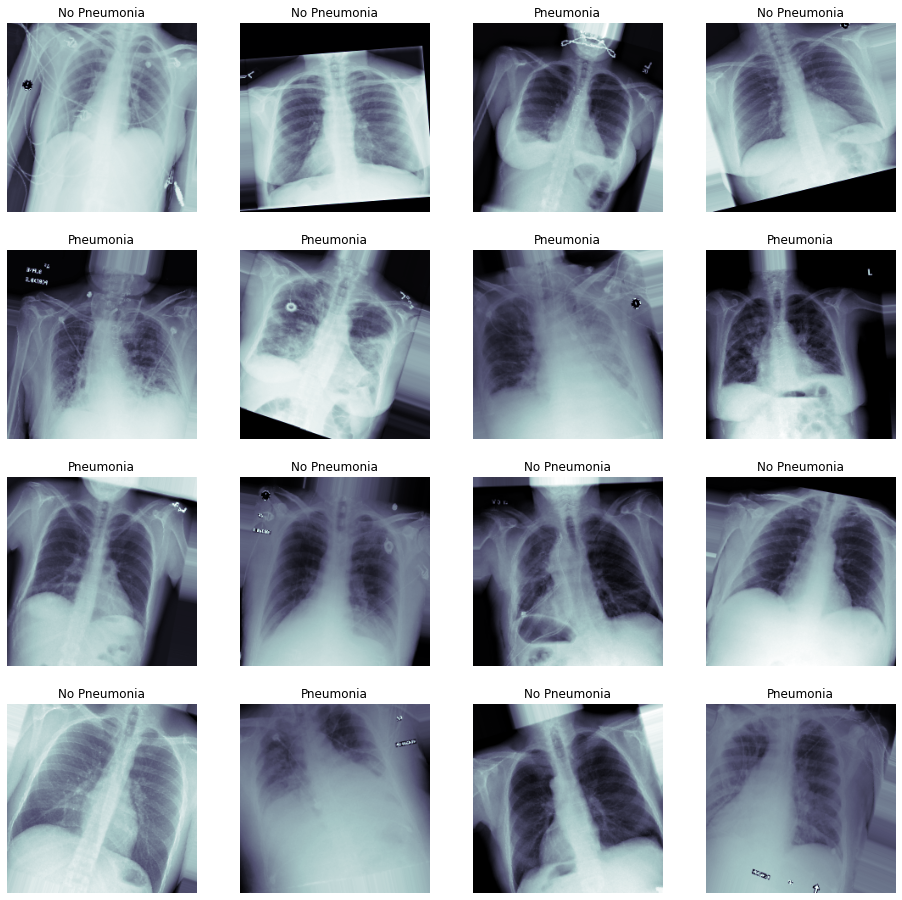

In [18]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [19]:
def load_pretrained_model():
    
#     model = ResNet50(include_top=False, weights='imagenet')
# #     transfer_layer = model.get_layer('conv5_block3_out')
#     new_model = Model(inputs = model.input, outputs = model.output)
    
#     for layer in new_model.layers[:-10]:
#         layer.trainable = False
    
    model = VGG16(include_top=True, weights='imagenet')
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[:17]:
        layer.trainable = False
        
    return vgg_model
#     return new_model


In [20]:
def build_my_model():
    
    my_model = load_pretrained_model()
    
#     my_model = Sequential([new_model,
#                         BatchNormalization(),
#                         Conv2D(1024, 1, activation='relu'),
#                         Dropout(0.5),
#                         BatchNormalization(),
#                         Conv2D(256, 1, activation='relu'),
#                         Dropout(0.5),                        
# #                         AveragePooling2D((7,7)),
# #                         BatchNormalization(),
#                         Conv2D(1, 1, activation='sigmoid'),
#                         Reshape((-1,))
#                        ])
    new_model = Sequential()
    new_model.add(my_model)
    new_model.add(Flatten())  
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.25))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.25))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.25))
    new_model.add(Dense(1, activation='sigmoid'))
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [21]:
my_model = build_my_model()
my_model.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_____________________________________________________

In [22]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [23]:
## train your model

my_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
36/36 [==============================] - 69s 2s/step - loss: 0.7325 - accuracy: 0.5253 - val_loss: 0.8432 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 0.84321, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
36/36 [==============================] - 61s 2s/step - loss: 0.6960 - accuracy: 0.5585 - val_loss: 0.6136 - val_accuracy: 0.7031

Epoch 00002: val_loss improved from 0.84321 to 0.61361, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
36/36 [==============================] - 62s 2s/step - loss: 0.6749 - accuracy: 0.5891 - val_loss: 0.7079 - val_accuracy: 0.5312

Epoch 00003: val_loss did not improve from 0.61361
Epoch 4/20
36/36 [==============================] - 62s 2s/step - loss: 0.6633 - accuracy: 0.6083 - val_loss: 0.7384 - val_accuracy: 0.4688

Epoch 00004: val_loss did not improve from 0.61361
Epoch 5/20
36/36 [==============================] - 61s 2s/step - loss: 0.6534 - accuracy: 0.6271 - val_loss: 0.7703 - val_accuracy: 0

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
my_model.load_weights(weight_path)

In [25]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
val_Y = val_df['pneumonia_class']
pred_Y = my_model.predict(val_gen, verbose = True)
# val_Y = valY
# pred_Y = my_model.predict(valX, batch_size = 64, verbose = True)

23/23 [==============================] - 31s 1s/step


In [26]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

## what other performance statistics do you want to include here besides AUC? 


def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    return

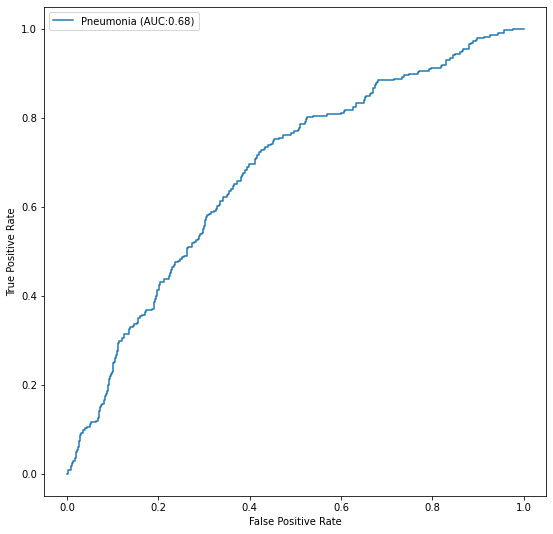

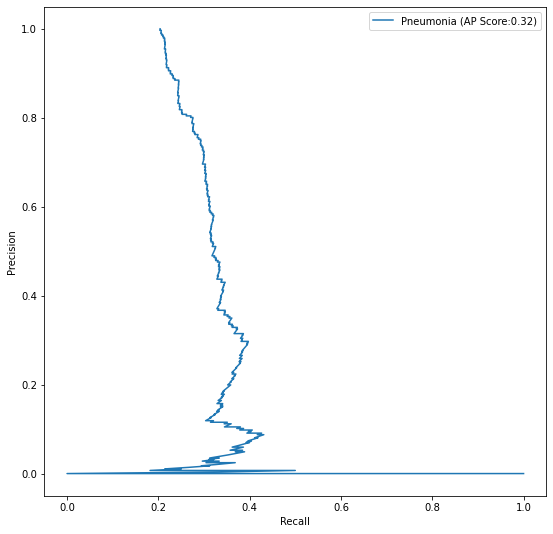

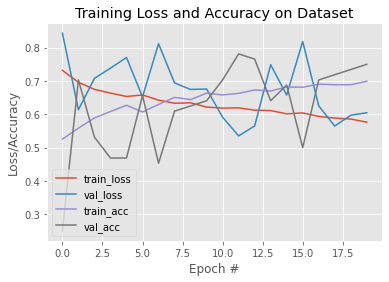

In [27]:
## plot figures

plot_auc(val_Y, pred_Y)
plot_pr(val_Y, pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [28]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.30043541364296084
Recall: 0.7237762237762237
Threshold: 0.55135345
F1 Score: 0.4246153846153847


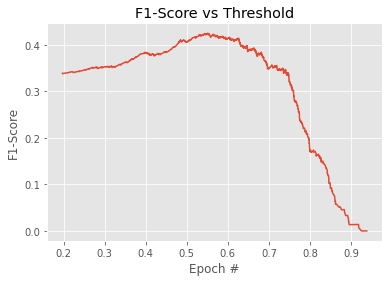

In [29]:
plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("Epoch #")
plt.ylabel("F1-Score")
plt.show()

In [30]:
YOUR_THRESHOLD = thresholds[idx]

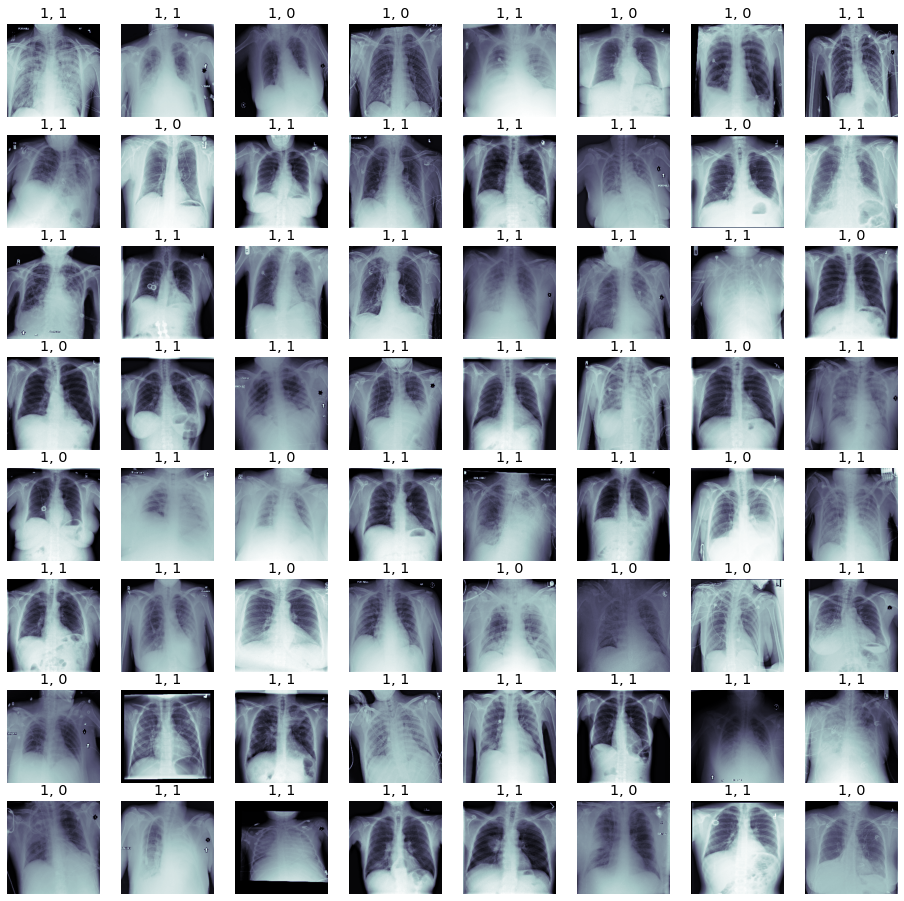

In [31]:
## Let's look at some examples of true vs. predicted with our best model: 

valX, valY = val_gen.next()
predY = my_model.predict(valX)
predY = predY.reshape(-1)

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(valX[0:64], valY[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if predY[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if predY[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [32]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)